In [1]:
!ls their_data

TMS_SCRIPT_2023JUL20.R
TMS_TRIAL_DATA_2023JUL20.csv
TMS_TRIAL_DICT_2023JUL20.csv


In [2]:
!cat their_data/TMS_TRIAL_DICT_2023JUL20.csv

COLUMN_LABEL,DESCRIPTION,VALUES
id,unique identification number assigned to each participant,integer between 1 and 108
randomization,randomly assigned treatment arm and order of intention,1 (R stimulation L intention first) or 2 (R stimulation R intention first) or 3 (L stimulation L intention first) or 4 (L stimulation R intention first) or 5 (S stimulation L intention first) or 6 (S stimulation R intention first)
tmsgroup,type of stimulation,1 (R stimulation) or 2 (L stimulation) or 3 (Sham stimulation)
condition,type of trial,experimental right (1) or control right (2) or experimental left (3) or control left (4)
trial,order of trials within a condition,integer from 1 to 500
reg,sum of 200 consecutive binary 0 or 1 digits within a trial,integer from 0 to 200


In [3]:
import pandas

tms_trial_data = pandas.read_csv("their_data/TMS_TRIAL_DATA_2023JUL20.csv")

In [4]:
tms_trial_data

,id,randomization,tmsgroup,condition,trial,reg
0,1,4,2,4,1,99
1,1,4,2,4,2,109
2,1,4,2,4,3,99
3,1,4,2,4,4,97
4,1,4,2,4,5,102
...,...,...,...,...,...,...
215995,108,4,2,1,496,98
215996,108,4,2,1,497,102
215997,108,4,2,1,498,101
215998,108,4,2,1,499,98


In [5]:
from collections import OrderedDict
import numpy as np

group_and_condition_to_trialdata = OrderedDict()

#gather the data for all of them
for group, group_easyname in [(1,"Rstim_Lfirst"),
                                              (2, "Rstim_Rfirst"),
                                              (3, "Lstim_Lfirst"),
                                              (4, "Lstim_Rfirst"),
                                              (5, "Sstim_Lfirst"),
                                              (6, "Sstim_Rfirst")]:
    group_and_condition_to_trialdata[group_easyname] = OrderedDict()
    for condition, condition_easyname in [(1, "expRight"),
                                          (2, "contRight"),
                                          (3, "expLeft"),
                                          (4, "contLeft")]:
        filtered_tms_data = tms_trial_data[(tms_trial_data["randomization"]==group)
                                           & (tms_trial_data["condition"]==condition)]
        trials_for_all_subjects = [] #gather the trials for all subjects into a list of lists
        subject_nums = set(filtered_tms_data["id"])
        for subject_num in sorted(subject_nums):
            data_for_subject = filtered_tms_data[filtered_tms_data["id"]==subject_num]
            #get the reg values, sorted in ascending order by trial number
            sorted_reg_values = np.array(data_for_subject["reg"])[np.argsort(data_for_subject["trial"])]            
            trials_for_all_subjects.append(sorted_reg_values)
        trials_for_all_subjects = np.array(trials_for_all_subjects)
        group_and_condition_to_trialdata[group_easyname][condition_easyname] = trials_for_all_subjects

Plot the trend in the effect for each condition (effect consists of "more ones")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


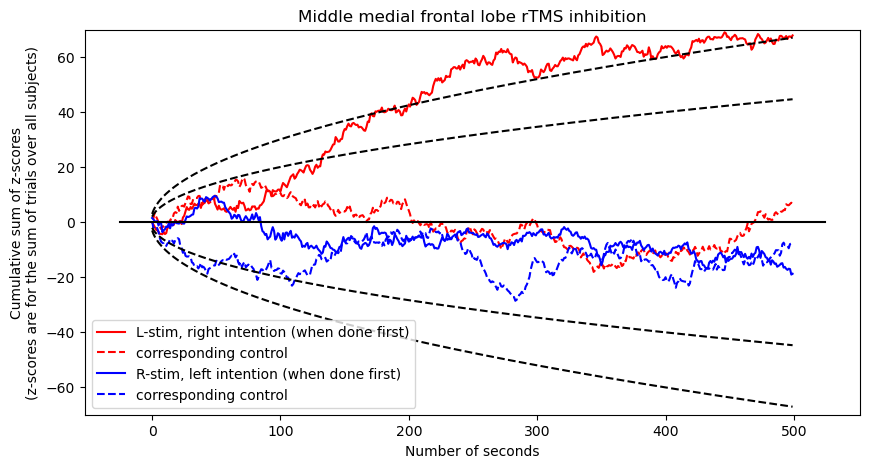

In [65]:
#plot to make sure
%matplotlib inline
from matplotlib import pyplot as plt

lines_to_plot = [
    ("Lstim_Rfirst", "expRight", 'red', '-', "L-stim, right intention (when done first)"),
    ("Lstim_Rfirst", "contRight", 'red', '--', "corresponding control"),
    ("Rstim_Lfirst", "expLeft", 'blue', '-', "R-stim, left intention (when done first)"),
    ("Rstim_Lfirst", "contLeft", 'blue', '--', "corresponding control"),
]

plt.figure(figsize=(10,5))
handles = []
handle_labels = []
for groupname, conditionname, color, linestyle, label in lines_to_plot:
    data = group_and_condition_to_trialdata[groupname][conditionname]
    handles.append(
         plt.plot(np.cumsum(np.sum(data-100, axis=0))/(np.sqrt(50)*np.sqrt(data.shape[0])),
                 color=conditionname_to_color[conditionname],
                 #alpha=conditionname_to_alpha[conditionname],
                 linestyle=conditionname_to_linestyle[conditionname])[0])
    handle_labels.append(label)
plt.title("Middle medial frontal lobe rTMS inhibition")
plt.ylabel("Cumulative sum of z-scores\n(z-scores are for the sum of trials over all subjects)")
plt.xlabel("Number of seconds")
plt.legend(handles=handles, labels=handle_labels, loc=3)
xlim = plt.xlim()
plt.plot(xlim, [0,0], color="black")
#2 sigma curve:
plt.plot(np.arange(data.shape[1]), 2*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.plot(np.arange(data.shape[1]), -2*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
#3 sigma curve:
plt.plot(np.arange(data.shape[1]), 3*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.plot(np.arange(data.shape[1]), -3*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.ylim(-70,70)
plt.savefig('contra_stim_first_intention_trials.eps', format='eps')

Check device variance

In [57]:
#verify that the device variance is <= the theoretical expectation of 50
#(means that using the theoretical variance is more conservative)
np.var(np.ravel(group_and_condition_to_trialdata["Lstim_Rfirst"]["contRight"][:,:]), axis=0)

49.05956365432099

Test for a decline effect within the Lstim_Rfirst_expRight group. Under the null hypothesis, the trials follow a normal distribution, so a t-test is justified.

In [48]:
import scipy.stats

vals_to_test_for_decline = group_and_condition_to_trialdata["Lstim_Rfirst"]["expRight"]
print("t-test for later half of trials against first half:",
      scipy.stats.ttest_ind(a=np.mean(vals_to_test_for_decline,axis=0)[:250],
                            b=np.mean(vals_to_test_for_decline,axis=0)[250:],
                            alternative='greater').pvalue)

t-test for later half of trials against first half: 0.013292820700504597


Plot the distribution of the effect for Lstim_Rfirst expRight for individual subjects

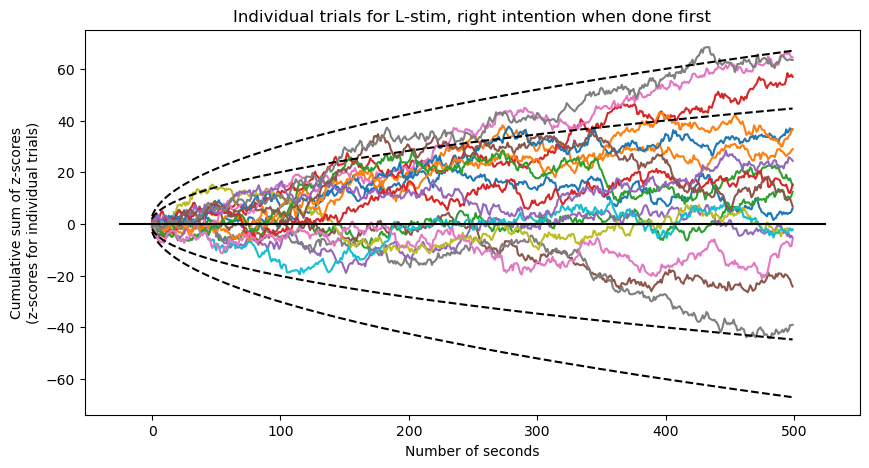

In [63]:
data = group_and_condition_to_trialdata["Lstim_Rfirst"]["expRight"]

fig = plt.figure(figsize=(10,5))

for i in range(data.shape[0]):
    plt.plot(np.cumsum(data[i,:]-100)/(np.sqrt(50)))
xlim = plt.xlim()
plt.plot(xlim, [0,0], color="black")
#2 sigma curve:
plt.plot(np.arange(data.shape[1]), 2*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.plot(np.arange(data.shape[1]), -2*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
#3 sigma curve:
plt.plot(np.arange(data.shape[1]), 3*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.plot(np.arange(data.shape[1]), -3*np.sqrt(1+np.arange(data.shape[1])), linestyle="--", color="black" )
plt.title("Individual trials for L-stim, right intention when done first")
plt.ylabel("Cumulative sum of z-scores\n(z-scores for individual trials)")
plt.xlabel("Number of seconds")
    
plt.savefig('Lstim_Rfirst_expRight_individual.eps', format='eps')
